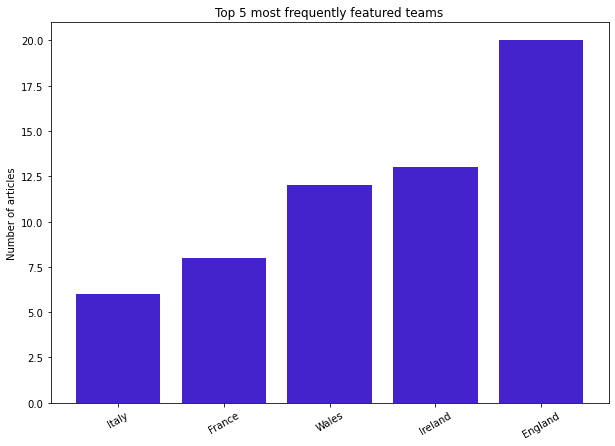

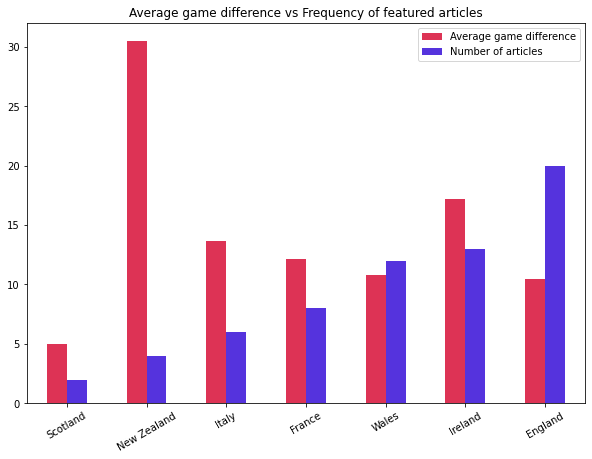

In [6]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import unicodedata
import re
import matplotlib.pyplot as plt
import csv
import json

# This code contains fragments of code provided in the week 5 workshop of Comp20008 Semester 2 2020.
# The borrowed code is only related to crawling operations.

### --- Retrieve the teams we need to find
team_names = []
with open('rugby.json') as json_file:
    data = json.load(json_file)
    for team in data['teams']:
        team_names.append(team['name'])

# Parse that into a string format
teams_regex_format = '('
for team in team_names:
    teams_regex_format = teams_regex_format + team + '|'
    
    
### --- Regex Formats
teams_regex_format = teams_regex_format.strip('|') + ')'
scores_regex_format = "[0-3]?[0-9]?[0-9]-[0-3]?[0-9]?[0-9]"
integer_regex_format = '[0-9]+'


### --- Initial page to crawl
page_limit = 300
seed_url = 'http://comp20008-jh.eng.unimelb.edu.au:9889/main/index.html'
# get the page, parse into bs
page = requests.get(seed_url)
soup = BeautifulSoup(page.text, 'html.parser')


### --- Remove index page, mark as visited
# find all links on this page
links = soup.findAll('a')
# find all links within that set that are index links
seed_links = soup.findAll('a', href=re.compile("^index.html"))


### --- Pages to visit that are not index pages
to_visit_relative = [l for l in links if l not in seed_links]
to_visit = []
# Turn to_visit links into absolute urls
for link in to_visit_relative:
    to_visit.append(urljoin(seed_url, link['href']))

    
### --- Keep track of the visited pages
visited = {}
visited[seed_url] = True
pages_visited = 1


### --- Here are the things we are looking for
headlines = {}
teams = {}
highest_scores = {}
game_differences = {}
    
    
### --- Visit all links
while (to_visit):
    
    # Avoid breaking the site 
    if pages_visited == page_limit:
        break
        
    # Get a link from the list and mark it as visited
    link = to_visit.pop(0)
    # Mark the link as visited
    visited[link] = True
    page = requests.get(link)
    
    ### Scrape the link
    # Parse the page content into BeautifulSoup
    soup = BeautifulSoup(page.text, 'html.parser')
        
    # TASK 1 - Find the headline of each article
    headline = soup.find(id='headline')
    headlines[link] = headline.text
    
    # Locate the body in preparation for task 2
    body = soup.find('body').text.strip()
    
    # TASK 2 - Find the first team in each article
    # Find the first team in the text of the body
    try:
        first_team = re.search(teams_regex_format, body).group()
        teams[link] = first_team
    except Exception as e:
        pass
        
    
    # TASK 2 - Find the largest match score in each article AND
    # TASK 3 - Find the average game differences for each team
    max_scores = [-1,-1]
    game_difference = -1
    scores_found = re.findall(scores_regex_format, body)
    # Compare every score found
    for string in scores_found:
        scores_str = re.findall(integer_regex_format, string)
        scores = [int(scores_str[0]), int(scores_str[1])]
        if scores[0] + scores[1] > max_scores[0] + max_scores[1]:
            max_scores = scores
            game_difference = abs(max_scores[0] - max_scores[1])
            
    if game_difference != -1:
        highest_scores[link] = str(max_scores[0]) + '-' + str(max_scores[1])
        game_differences[link] = game_difference
          

    ### Find more links to crawl
    new_links = soup.findAll('a')
    for new_link in new_links:
        new_item = new_link['href']
        new_url = urljoin(link, new_item)
        if new_url not in visited and new_url not in to_visit:
            to_visit.append(new_url)
    
    pages_visited = pages_visited + 1

    

##### TASK 1 --- Write headlines into task1.csv file

# Turn headlines into a pandas Series
headlines = pd.Series(headlines)
headlines = headlines.sort_index()

# Create file task1.csv
with open('task1.csv', 'w') as task1:
    writer = csv.writer(task1)
    writer.writerow(['url','headline'])
    for key in headlines.keys():
        writer.writerow([key, headlines[key]])
    
    
##### TASK 2 --- Create a table with urls, headlines, teams and scores

# Turn teams into a pandas Series
teams = pd.Series(teams)
teams = teams.sort_index()

# Turn highest_scores into a pandas Series
highest_scores = pd.Series(highest_scores)
highest_scores = highest_scores.sort_index()

# Prune out missing data and write to file task2.csv
task2 = pd.DataFrame({'headline':headlines, 'team':teams, 'score':highest_scores})
task2.index.name = 'url'
task2 = task2[task2.team.notnull()]
task2 = task2[task2.score.notnull()]
task2.to_csv('task2.csv')


##### TASK 3 --- Find the average difference

# Get the game differences and teams and merge into one DataFrame
game_differences = pd.Series(game_differences)
game_differences = game_differences.sort_index()
game_differences = pd.DataFrame({'team':task2.team, 'game_difference':game_differences})
game_differences = game_differences[game_differences.team.notnull()]
game_differences = game_differences[game_differences.game_difference.notnull()]
grouped = game_differences.groupby(game_differences.team)

# Group the data by teams and then calculate their averages
team_avg = {}
for team in team_names:
    group = grouped.get_group(team)
    average = group['game_difference'].mean()
    team_avg[team] = average
team_avg = pd.Series(team_avg).sort_values()

# Write to file task3.csv
with open('task3.csv', 'w') as task3:
    writer = csv.writer(task3)
    writer.writerow(['team', 'avg_game_difference'])
    for team in team_avg.index:
        writer.writerow([team, team_avg[team]])

        
#### TASK 4 --- Find the 5 most frequently mentioned teams

# Count the teams and take the top 5
task4 = task2.team.value_counts()
try:
    task4 = task4[:5]
except Exception as e:
    pass

task4 =  task4.sort_values()
# Plot the data and save to file task4.png
plt.figure(figsize=(10,7))
plt.xticks(rotation=30)
plt.bar(task4.index, task4.values, color = '#42c')
plt.ylabel('Number of articles')
plt.title('Top 5 most frequently featured teams')
plt.savefig('task4.png')


##### TASK 5 --- Teams' frequency of mention vs average game difference

# Count the teams, merge with team average data into a DataFrame
team_freq = task2.team.value_counts()
# team_avg = pd.Series(team_avg)
task5 = pd.DataFrame({'Average game difference':team_avg, 'Number of articles':team_freq})
task5 = task5[task5['Average game difference'].notnull()]
task5 = task5[task5['Number of articles'].notnull()]

# Plot the data and save to file task5.png
task5 = task5.sort_values(by='Number of articles', ascending = True)

task5.plot.bar(rot=30, color = ["#d35", "#53d"], figsize=(10,7), title='Average game difference vs Frequency of featured articles')
plt.savefig('task5.png')